In [1]:
# Python 3.9.5
# qpsolvers 4.0.0
# SCS 3.2.3
# Mosek 10.1

In [2]:
%matplotlib inline

In [3]:
from grale.all_nb import *
import matplotlib
import subprocess
from IPython.display import display, HTML
import os
import pprint

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [4]:
feedback.setDefaultFeedback("none")

In [5]:
cosm = cosmology.Cosmology(0.7,0.3,0,0.7)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

In [6]:
zd = 0.5
zs_lines = 2.0

nsie1 = lenses.NSIELens(D(zd),{ "ellipticity": 0.65, "coreRadius": 5*ANGLE_ARCSEC, "velocityDispersion": 1500000 })
nsie2 = lenses.NSIELens(D(zd),{ "ellipticity": 0.65, "coreRadius": 5*ANGLE_ARCSEC, "velocityDispersion": 1000000 })
extraPeak = lenses.NSIELens(D(zd), { "ellipticity": 0.99, "coreRadius": 4*ANGLE_ARCSEC, "velocityDispersion": 900000})
startLensParams = [
    { "x": -20*ANGLE_ARCSEC, "y": -25*ANGLE_ARCSEC, "angle": 140, "factor": 1, "lens": nsie1 },
    { "x": 40*ANGLE_ARCSEC, "y": 40*ANGLE_ARCSEC, "angle": 140, "factor": 1, "lens": nsie2 },
    { "x": -70*ANGLE_ARCSEC, "y": 70*ANGLE_ARCSEC, "angle": 0, "factor": 1, "lens": extraPeak },
]
startLens = lenses.CompositeLens(D(zd), startLensParams)
startLensWithoutPeak = lenses.CompositeLens(D(zd), startLensParams[:2])

plotSize = 180*ANGLE_ARCSEC
li = plotutil.LensInfo(startLens, size=plotSize, zd=zd, zs=zs_lines)
liDetail = plotutil.LensInfo(startLens, size=plotSize, zd=zd, zs=zs_lines, numxy=2047)
critDens = startLens.getCriticalDensity(D(zs_lines), D(zd, zs_lines))

In [7]:
def drawCircle(xc, yc, r):
    a = np.linspace(0,2.0*np.pi,100)
    pts = V(r*np.cos(a)+xc, r*np.sin(a)+yc).T
    plt.plot(pts[:,0], pts[:,1], '--', color="green")

In [8]:
circularParams = 5,5,70

In [9]:
sourceParams = [
    (1.5, -8, -8, 0.8),
    (2.0, 5, 20, 0.8),
    (1.0, -20, -8, 0.7),
    (2.5, -10, 10.5, 0.8),
]

sources = [ { "shape": images.CircularSource(V(x,y)*ANGLE_ARCSEC, sz*ANGLE_ARCSEC), "z": zs } for zs, x, y, sz in sourceParams ]

In [10]:
def getPointImagesData(pts):
    img = images.ImagesData(pts.shape[0])
    for i in range(pts.shape[0]):
        img.addPoint(i, pts[i,:])
    return img

In [11]:
pointImagePositions = []
for zs, x, y, unused_sz in sourceParams:
    li.setSourceRedshift(zs)
    pointImagePositions.append(np.array(li.getImagePlane().traceBeta(V(x,y)*ANGLE_ARCSEC)))

In [12]:
def getImagesData(lensInfo, src, zs, asSource=False):
    lensInfo.setSourceRedshift(zs)
    ip = lensInfo.getImagePlane()
    pts = ip.segment(ip.renderImages([src]) if not asSource else ip.renderSources([src]))
    imgDat = images.ImagesData(len(pts))
    for idx in range(len(pts)):
        for pt in pts[idx]:
            imgDat.addPoint(idx, pt)
            
    return imgDat

In [13]:
ptImgList = [
    { "z": sp[0], "imgdata": getPointImagesData(ptDat)} for sp, ptDat in zip(sourceParams, pointImagePositions)
]

ptSrcList = [
    { "z": zs, "imgdata": getPointImagesData(np.array([[x,y]])*ANGLE_ARCSEC) } for zs, x, y, sz in sourceParams
]

imgList = [
    { "z": zs, "imgdata": getImagesData(liDetail, images.CircularSource(V(x,y)*ANGLE_ARCSEC, sz*ANGLE_ARCSEC), zs)} for zs, x, y, sz in sourceParams
]

srcList = [
    { "z": zs, "imgdata": getImagesData(liDetail, images.CircularSource(V(x,y)*ANGLE_ARCSEC, sz*ANGLE_ARCSEC), zs, True)} for zs, x, y, sz in sourceParams
]

iws = inversion.InversionWorkSpace(zd, 180*ANGLE_ARCSEC)
for i in imgList:
    iws.addImageDataToList(i["imgdata"], i["z"], "extendedimages")

In [14]:
def plotImgData(imgDat, ptImgDat, marker, markerSize, markerSize2, color):
    allPts = list(imgDat.getAllImagePoints())
    pts = np.array([ x["position"] for img in allPts for x in img ])/ANGLE_ARCSEC
    plt.plot(pts[:,0], pts[:,1], 's', ms=markerSize, color=color)
    plt.gca().set_aspect("equal")
    
    if ptImgDat and markerSize2:
        for img in list(ptImgDat.getAllImagePoints()):
            ctr = img[0]["position"]/ANGLE_ARCSEC
            plt.plot([ctr[0]], [ctr[1]], marker, ms=markerSize2, mfc="none", mec=color)

In [15]:
def plotImagePlane(li, linestyle="-", markerSize=0.3, markerSize2=13, color="red", lw=1, halfSize=90, trace=True):
    li.setSourceRedshift(zs_lines)
    ip = li.getImagePlane()
    for l in ip.getCriticalLines():
        l = np.array(l)/ANGLE_ARCSEC
        plt.plot(l[:,0], l[:,1], linestyle, color=color, lw=lw)

    if trace:
        imgListTraced = [ getImagesData(li, images.CircularSource(V(x,y)*ANGLE_ARCSEC, sz*ANGLE_ARCSEC), zs) for zs, x, y, sz in sourceParams ]
        for img in imgListTraced:
            plotImgData(img, None, 'o', markerSize, 0, "black")
        
    for i,marker in enumerate('osDp'):
        plotImgData(imgList[i]["imgdata"], ptImgList[i]["imgdata"], marker, markerSize, markerSize2, "black")
    plt.gca().set_xticks([-120, -90, -60, -30, 0, 30, 60, 90, 120])
    plt.gca().set_yticks([-120, -90, -60, -30, 0, 30, 60, 90, 120])
    plt.gca().set_xlim([halfSize,-halfSize])
    plt.gca().set_ylim([-halfSize,halfSize])

    plt.gca().set_xlabel(r"$\theta_x$ (arcsec)")
    plt.gca().set_ylabel(r"$\theta_y$ (arcsec)")

In [16]:
def plotSourcePlane(li, linestyle='-', markerSize=0.85, markerSize2=15, color="blue", lw=1, extraSpace=0, extraoff=[0,0]):
    li.setSourceRedshift(zs_lines)
    ip = li.getImagePlane()
    for l in ip.getCaustics():
        l = np.array(l)/ANGLE_ARCSEC
        plt.plot(l[:,0], l[:,1], linestyle, color=color, lw=lw)

    for i,marker in enumerate('osDp'):
        plotImgData(srcList[i]["imgdata"], ptSrcList[i]["imgdata"], marker, markerSize, markerSize2, "black")
    plt.gca().set_xlim([25+extraSpace+extraoff[0],-45-extraSpace+extraoff[0]])
    plt.gca().set_ylim([-25-extraSpace+extraoff[1],45+extraSpace+extraoff[1]])
    plt.gca().set_xlabel(r"$\beta_x$ (arcsec)")
    plt.gca().set_ylabel(r"$\beta_y$ (arcsec)")

In [17]:
def plot2DDensity(li, plotCircle=True):
    zMax = 3.5
    
    plotutil.plotDensityContours(li, densityUnit=critDens, levels=np.arange(0.2, zMax, 0.2), linewidths=0.5, colors="black", linestyles="-")
    plotutil.plotDensityContours(li, densityUnit=critDens, levels=[1], linewidths=[2], colors="black")
    if plotCircle:
        drawCircle(*circularParams)
    plt.gca().invert_xaxis()
    plt.gca().set_xticks([-90, -60, -30, 0, 30, 60, 90])
    plt.gca().set_yticks([-90, -60, -30, 0, 30, 60, 90])
    plt.gca().set_xlabel(r"$\theta_x$ (arcsec)")
    plt.gca().set_ylabel(r"$\theta_y$ (arcsec)")

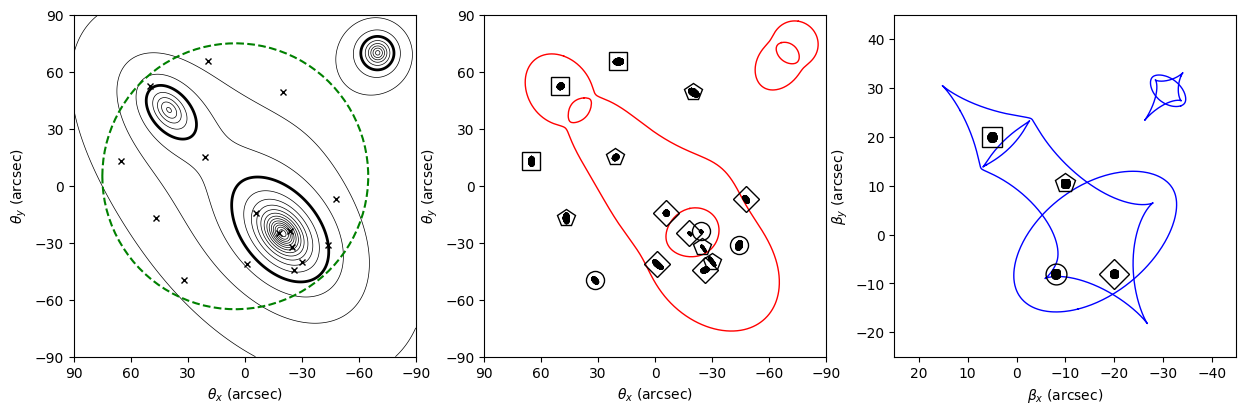

In [18]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plot2DDensity(li)
for i,marker in enumerate('xxxx'):
    plotImgData(imgList[i]["imgdata"], ptImgList[i]["imgdata"], marker, 0, 5, "black")

plt.subplot(1,3,2)
plotImagePlane(li)
plt.subplot(1,3,3)
plotSourcePlane(li)

In [19]:
HW = 120
blPot, trPot = -V(HW,HW)*ANGLE_ARCSEC, V(HW,HW)*ANGLE_ARCSEC

In [20]:
def getRealPtThetas():
    realThetas = []
    for i in range(len(ptSrcList)):
        zs = ptSrcList[i]["z"]
        for imgIdx, img in enumerate(ptSrcList[i]["imgdata"].getAllImagePoints()):
            thetasReal = [ p[0]["position"] for p in ptImgList[i]["imgdata"].getAllImagePoints() ]
            realThetas += thetasReal

    return np.array(realThetas)

def getEstPtThetas(li):
    estThetas = []
    for i in range(len(ptSrcList)):
        zs = ptSrcList[i]["z"]
        li.setSourceRedshift(zs)
        ip = li.getImagePlane()
        for imgIdx, img in enumerate(ptSrcList[i]["imgdata"].getAllImagePoints()):
            beta = img[0]["position"]
            thetasEst = ip.traceBeta(beta)
            estThetas += thetasEst
            
    return np.array(estThetas)

def calcRMSEstThetas(estThetasArcsec):
    realThetas = getRealPtThetas()/ANGLE_ARCSEC
    rms = np.mean(np.sum((realThetas - estThetasArcsec)**2,axis=1))**0.5
    return rms, realThetas, estThetasArcsec

def calcRMS(li):
    estThetas = getEstPtThetas(li)/ANGLE_ARCSEC
    return calcRMSEstThetas(estThetas)

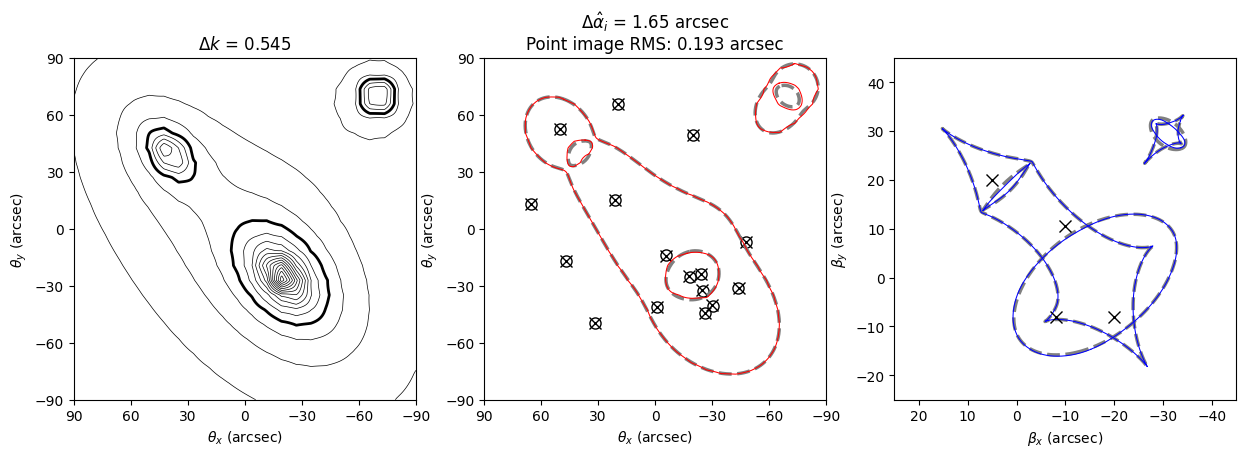

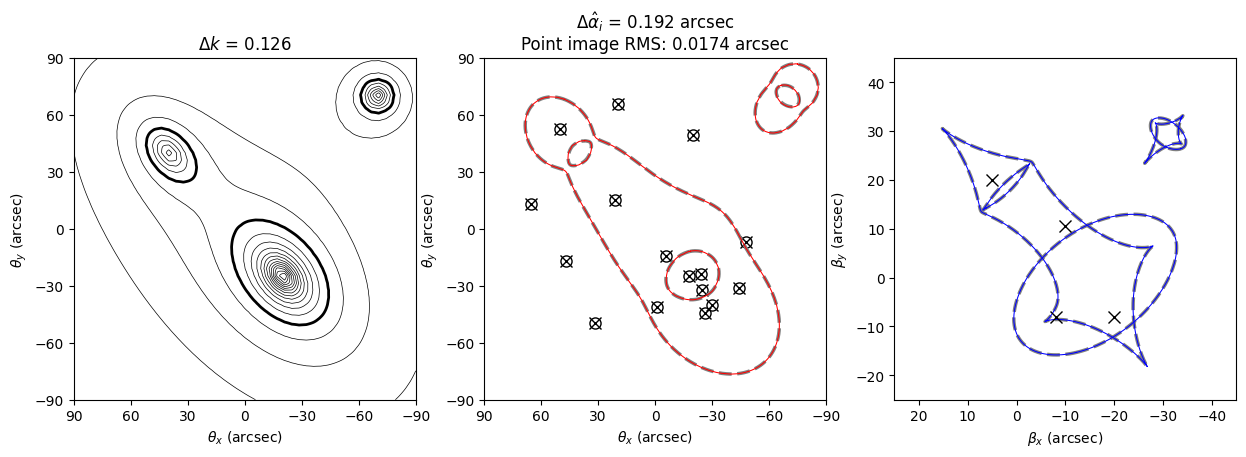

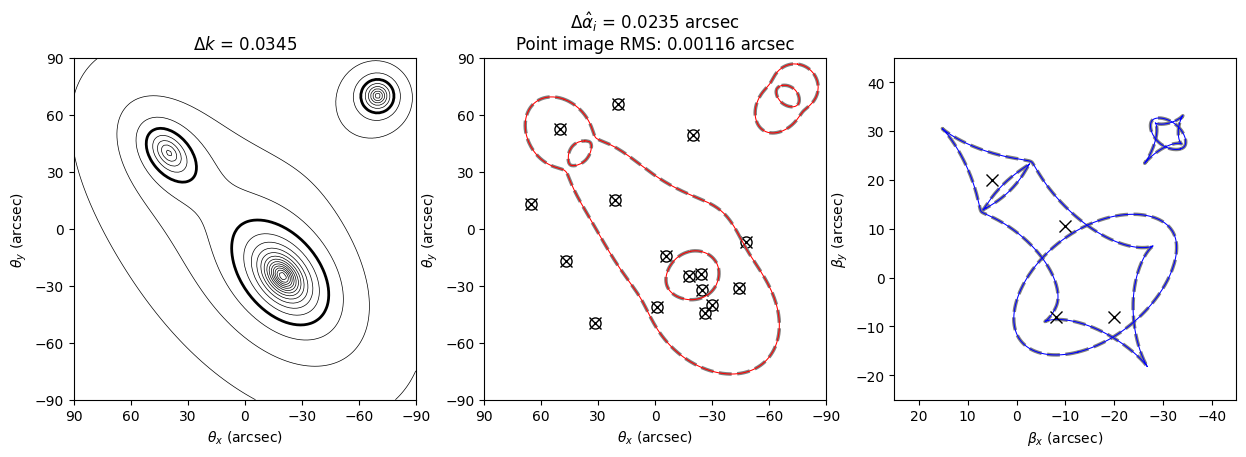

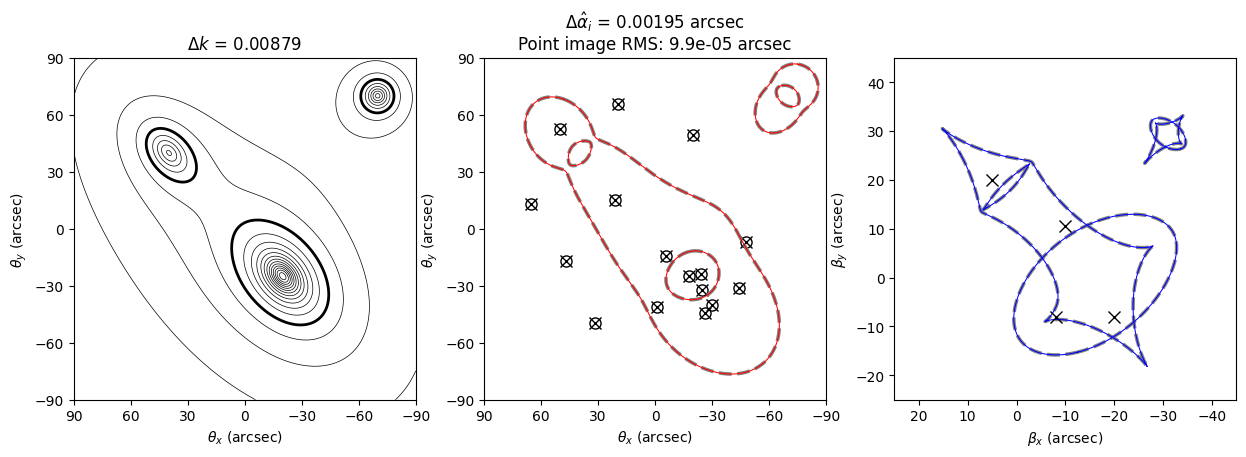

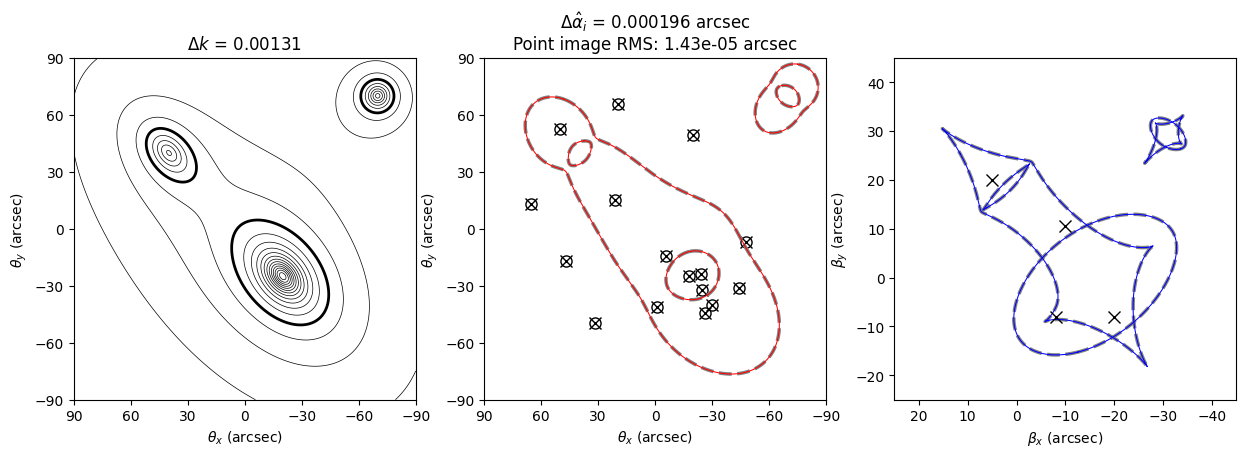

In [21]:
props = []
liApprox = {}
for N in [32, 64, 128, 256, 512]:
    thetas = util.createThetaGrid(blPot, trPot, N, N)
    phi = startLens.getProjectedPotential(1.0,1.0,thetas)
    
    phiLens = lenses.PotentialGridLens(startLens.getLensDistance(), { "values": phi, "bottomleft": blPot, "topright": trPot })
    phiLi = plotutil.LensInfo(phiLens, size=plotSize, zd=zd, zs=zs_lines)
    liApprox[N] = phiLi
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plot2DDensity(phiLi, plotCircle=False)
    densDiff = np.max(abs(li.getDensityPoints() - phiLi.getDensityPoints()))/critDens
    plt.title(f"$\\Delta k$ = {densDiff:.3g}")
    
    plt.subplot(1,3,2)
    rms, realThetas, estThetas = calcRMS(phiLi)
    
    ptImgSize=8
    plt.plot(realThetas[:,0], realThetas[:,1], 'x', color="black", ms=ptImgSize)
    plt.plot(estThetas[:,0], estThetas[:,1], 'o', color="black", mfc="none", ms=ptImgSize)
    
    plotImagePlane(li, "--", markerSize=0, markerSize2=0, color="gray", lw=2.5)
    plotImagePlane(phiLi, "-", markerSize=0, markerSize2=0, lw=0.75)
    
    thetas = util.createThetaGrid(li.getArea()["bottomleft"], li.getArea()["topright"], li.getNumXPoints(), li.getNumYPoints())
    a0 = startLens.getAlphaVector(thetas)
    a1 = phiLens.getAlphaVector(thetas)
    aDiff = np.max(abs(a1-a0))/ANGLE_ARCSEC
    plt.title("$\\Delta\\hat{\\alpha}_i$ = " + f"{aDiff:.3g} arcsec" + "\n" + f"Point image RMS: {rms:.3g} arcsec")
    
    plt.subplot(1,3,3)
    plotSourcePlane(li, "--", markerSize=0, markerSize2=0, color="gray", lw=2.5)
    plotSourcePlane(phiLi, "-", markerSize=0, markerSize2=0, lw=0.75)
    
    realBetas = np.array([ p[0]["position"] for s in ptSrcList for p in s["imgdata"].getAllImagePoints() ])/ANGLE_ARCSEC
    plt.plot(realBetas[:,0], realBetas[:,1], 'x', color="black", ms=ptImgSize)
    
    props.append([N, densDiff, aDiff, rms])

In [22]:
print("  N |        Δκ | Δα_i (arcsec) | Point image RMS (arcsec)")
print("----------------------------------------------------------")
for p in props:
    N, dk, da, rms = p
    print(f"{N:3d} | {dk:9.3g} | {da:13.3g} | {rms:10.3g}")


  N |        Δκ | Δα_i (arcsec) | Point image RMS (arcsec)
----------------------------------------------------------
 32 |     0.545 |          1.65 |      0.193
 64 |     0.126 |         0.192 |     0.0174
128 |    0.0345 |        0.0235 |    0.00116
256 |   0.00879 |       0.00195 |    9.9e-05
512 |   0.00131 |      0.000196 |   1.43e-05


In [23]:
K_5_BB = np.array([[  0, 0,  1, 0, 0 ],
                   [  0, 1,  2, 1, 0 ],
                   [  1, 2,-16, 2, 1 ],
                   [  0, 1,  2, 1, 0 ],
                   [  0, 0,  1, 0, 0 ]],dtype=np.double)

In [24]:
def createEquiv(qpsolver, potGradWeight, densGradWeight, densWeight, N, kernel, circle,
                boundardyWidth, boundaryType, exactOrMax, targetDensFactors,
                feedbackObject):

        # Start from the circular region or from the images
    if circle:
        reg = [ { "type": "circle", "center": V(circularParams[0], circularParams[1])*ANGLE_ARCSEC, "radius": circularParams[2]*ANGLE_ARCSEC } ]
        pixEnlarge = 2
    else:
        reg = [ i["imgdata"] for i in imgList ]
        pixEnlarge = 3
        
    thetas, mask = util.createThetaGridAndImagesMask(blPot, trPot, N, N,
                                                     reg, enlargements=pixEnlarge)
    
    reg = [ mask ]

    exactDensConst = []
    maxDensConst = []
    
    if boundardyWidth > 0:
      
        densMask = np.zeros((N,N),dtype=bool)

        BW = boundardyWidth
        densMask[:BW,:] = True
        densMask[-BW:,:] = True
        densMask[:,:BW] = True
        densMask[:,-BW:] = True
        
        if boundaryType == "originalpotential":
            reg.append(densMask) # Mark the boundary as potential values to keep
            if targetDensFactors is not None:
                raise Exception("'targetDensFactors' should be None")
            if exactOrMax is not None:
                raise Exception("'exactOrMax' should be None")
        else: # It's abount the density
            if type(boundaryType) == float:
                targetDens = float(boundaryType)
            elif boundaryType == "original":
                targetDens = startLens.getSurfaceMassDensity(thetas)
            elif boundaryType == "nopeak":
                targetDens = startLensWithoutPeak.getSurfaceMassDensity(thetas)
            else:
                raise Exception("boundaryType should either be a float or 'original'")

            if exactOrMax == "exact":
                exactDensConst = [ { "density": targetDens * targetDensFactors, "maskRegions": [ densMask ]  } ]
            elif exactOrMax == "max":
                maxDensConst = [ { "density": targetDens * targetDensFactors, "maskRegions": [ densMask ]  } ]
            elif exactOrMax == "approx":
                maxDensConst = [ { "density": targetDens*targetDensFactors[1], "maskRegions": [ densMask ], "upperlimit": True  },
                                 { "density": targetDens*targetDensFactors[0], "maskRegions": [ densMask ], "upperlimit": False  },
                               ]
    else:
        if boundaryType is not None:
            raise Exception("boundaryType should be set to None")

    #print("reg =")
    #pprint.pprint(reg)

    r = lenses.createEquivalentPotentialGridLens(startLens, blPot, trPot, N, N,
                                                 reg,
                                                 potGradWeight, densGradWeight, densWeight,
                                                 laplacianKernel=kernel,
                                                 qpsolver=qpsolver,
                                                 feedbackObject=feedbackObject,
                                                 exactDensityConstraints=exactDensConst,
                                                 maxDensityConstraints=maxDensConst,
                                                 pixelEnlargements=0, # We have enlarged this at the top of the function
                                                )

    liEq = plotutil.LensInfo(r["philens_equiv"], size=plotSize, zd=zd, zs=zs_lines)
    return liEq, r

In [25]:
def plotEquiv(liEq, plotCircle):

    def plotImgs():
        for zs, x, y, sz in sourceParams:
            imgDat = getImagesData(liEq, images.CircularSource(V(x,y)*ANGLE_ARCSEC, sz*ANGLE_ARCSEC), zs)
            plotImgData(imgDat, None, 'x', 0.3, 0, "black")

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plot2DDensity(liEq, plotCircle)
    if not plotCircle:
        #plotImgs() # This is called again below anyway
        for i,marker in enumerate('xxxx'):
            plotImgData(imgList[i]["imgdata"], ptImgList[i]["imgdata"], marker, 0, 4, "grey")
    
    plt.subplot(1,2,2)
    plotImagePlane(li, "--", markerSize=0, markerSize2=0, color="gray", lw=2.5)
    plotImagePlane(liEq, "-", markerSize=0, markerSize2=0, lw=0.75)
    plotImgs()
    
    if plotCircle:
        drawCircle(*circularParams)
        
    plotutil.plotDensityInteractive(liEq, densityUnit=critDens, flipX=True, visJSoptions={"zMin": 0, "zMax": 3.5})

In [26]:
def createEquivAndPlot(N, solver, kernelName, potGradWeight, densGradWeight, densWeight, circle, boundaryWidth,
                       boundaryType, exactOrMax, targetDensFactors, plot):
       
    if kernelName == "K_5_BB": kernel=K_5_BB
    else:
        raise Exception("Unknown kernel name")
    
    liEq, r = createEquiv(solver, N=N, kernel=kernel, potGradWeight=potGradWeight, densGradWeight=densGradWeight, 
                          densWeight=densWeight, circle=circle, boundardyWidth=boundaryWidth, boundaryType=boundaryType,
                          exactOrMax=exactOrMax, targetDensFactors=targetDensFactors, feedbackObject="stdout")
    if plot:
        plotEquiv(liEq, circle)
    
    liWide = plotutil.LensInfo(r["philens_equiv"], size=225*ANGLE_ARCSEC, cosmology=cosm, zd=zd)
    
    if plot:
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plotImagePlane(liWide, halfSize=113)
        plt.subplot(1,2,2)
        plotSourcePlane(liWide, extraSpace=15)
    return liEq, r

In [27]:
# First two keep potential values inside circle
liEq1, r1  = createEquivAndPlot(128, "mosek", "K_5_BB", 0.000001, 1, 0, True, 5, "original", "exact", 1.0, False)
liEq2, r2  = createEquivAndPlot(128, "mosek", "K_5_BB", 0.000001, 1, 0, True, 5, "originalpotential", None, None, False)
# This one keeps the potential values at the image positions
liEq3, r3  = createEquivAndPlot(128, "mosek", "K_5_BB", 0.000001, 1, 0, False, 5, "originalpotential", None, None, False)

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 10.3 seconds
STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 6.14 seconds
STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 11 seconds


In [28]:
def plotEquiv(liEq, plotCircle):
    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plot2DDensity(liEq, plotCircle)
    if not plotCircle:
        #plotImgs() # This is called again below anyway
        for i,marker in enumerate('xxxx'):
            plotImgData(imgList[i]["imgdata"], ptImgList[i]["imgdata"], marker, 0, 4, "grey")
    
    plt.subplot(1,2,2)
    plotImagePlane(li, "--", markerSize=0, markerSize2=0, color="gray", lw=2.5)
    plotImagePlane(liEq, "-", markerSize=0, markerSize2=0, lw=0.75)
    #plotImgs()
    
    if plotCircle:
        drawCircle(*circularParams)
        
    plotutil.plotDensityInteractive(liEq, densityUnit=critDens, flipX=True, visJSoptions={"zMin": 0, "zMax": 3.5})

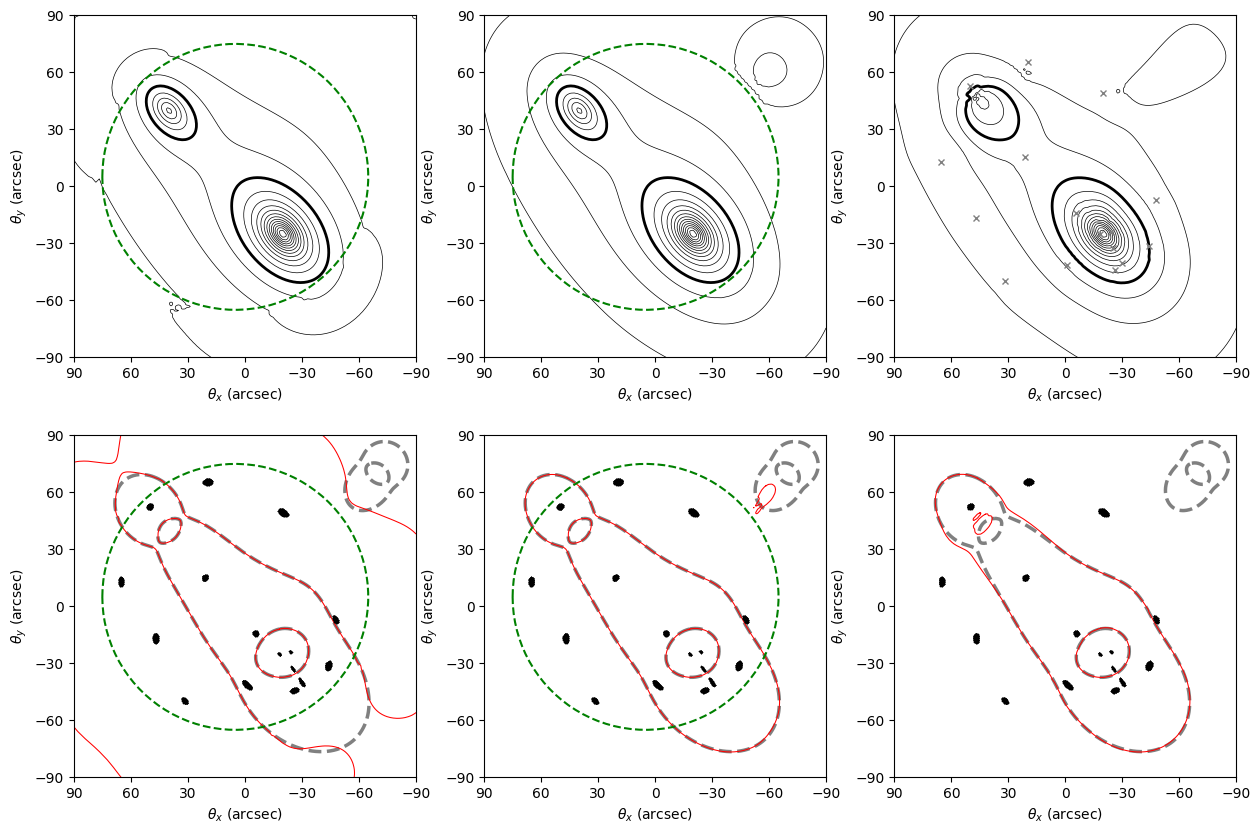

In [29]:
def iplanePlot(liEq, plotCircle):
    def plotImgs():
        for zs, x, y, sz in sourceParams:
            imgDat = getImagesData(liEq, images.CircularSource(V(x,y)*ANGLE_ARCSEC, sz*ANGLE_ARCSEC), zs)
            plotImgData(imgDat, None, 'x', 0.3, 0, "black")

    plotImagePlane(li, "--", markerSize=0, markerSize2=0, color="gray", lw=2.5)
    plotImagePlane(liEq, "-", markerSize=0, markerSize2=0, lw=0.75)
    plotImgs()
    
    if plotCircle:
        drawCircle(*circularParams)


plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plot2DDensity(liEq1, True)

plt.subplot(2,3,2)
plot2DDensity(liEq2, True)

plt.subplot(2,3,3)
plot2DDensity(liEq3, False)
for i,marker in enumerate('xxxx'):
            plotImgData(imgList[i]["imgdata"], ptImgList[i]["imgdata"], marker, 0, 4, "grey")

plt.subplot(2,3,4)
iplanePlot(liEq1, True)

plt.subplot(2,3,5)
iplanePlot(liEq2, True)

plt.subplot(2,3,6)
iplanePlot(liEq3, False)

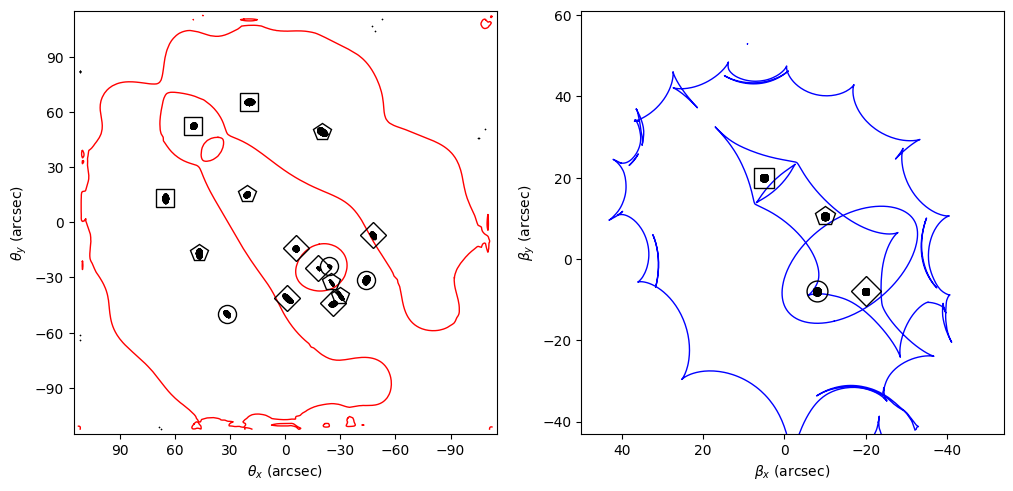

In [30]:
liWide = plotutil.LensInfo(r1["philens_equiv"], size=225*ANGLE_ARCSEC, zd=zd)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plotImagePlane(liWide, halfSize=115)
plt.subplot(1,2,2)
plotSourcePlane(liWide, extraSpace=17, extraoff=[8,-1])

In [31]:
# Upon re-running the code in the notebook, the results for this last image, as 
# well as the right column of the previous one seem to differ somewhat. Further
# experiments indicate that this particular case is quite sensitive to the
# software versions used, even the precise hardware and number of cores used.
# (8 cores on p33c25n2 node of wice cluster in this case)